In [2]:
#Scraping Imports
import requests
from bs4 import BeautifulSoup
from datetime import datetime

#Others
import pandas as pd
import sqlite3
import re

## 1. Overall Strategy

Rather than using 'heavy duty' methods like Selenium or employing other headless browsers, the URA real estate search form lends itself to a straightforward post requests approach despite its use of Javascript and Jquery, which usually makes it tricky to scrape.

There are 2 main reasons for using this:

1) Selenium/Other headless browsers are slower, more computational expensive, and require more network resources.

2) There are no protections in place (e.g. hit rate), so this approach scales well. For more 'ethical' scraping, especially if scaling this up, I might add a short timer in between hitting the URA database so as to not flood them with requests.

## 2. Creating SQLite Table

Create a new table called ura_rental if it doesn't already exist.

In [8]:
#The issue with the URA database is that there are no unique identifiers per rental contract
#It doesn't seem possible to detect and delete duplicate entries
#For now, I will clear the database whenever scraping the URA website to avoid having duplicates when repeating the process.
def delete_all_tasks(conn):
    sql = 'DELETE FROM ura_rental'
    cur = conn.cursor()
    cur.execute(sql)
    conn.commit()

In [56]:
conn = sqlite3.connect('ura_scraper.db')
c = conn.cursor()
# Create table
c.execute('''CREATE TABLE IF NOT EXISTS ura_rental
             (Building_Project_Name, Street_Name, Postal_District, Type,
             No_of_Bedrooms, Monthly_Rent, Floor_Area, Lease_Commencement_Date, Downloaded_At)''')


## 3. Get list of all Projects

From the URA search form, there are two means of searching the URA database: by project name, or by postal code. Both approaches work, but in this case I will be using project names.

The code below extracts all current project names, so I can iterate through them to get all projects within the defined time frame.

In [57]:
url = 'https://www.ura.gov.sg/realEstateIIWeb/resiRental/search.action'
res = requests.get(url)
soup = BeautifulSoup(res.text, 'lxml')
project_names = soup.find_all('div', {'class':'projectListingContainer'})[0].find_all('option')
project_names = [project.text for project in project_names]
project_names

['# 1 LOFT',
 '# 1 SUITES',
 '1 CANBERRA',
 '1 KING ALBERT PARK',
 '1 MOULMEIN RISE',
 '1 NASSIM',
 '10 SHELFORD',
 '100 AM',
 '105 LORONG G',
 '11 AMBER ROAD',
 '111 EMERALD HILL',
 '16 @ AMBER',
 '18 SHELFORD',
 '18 WOODSVILLE',
 '183 LONGHAUS',
 '1919',
 '2 RVG',
 '21 ANDERSON',
 '21 RICHARDS',
 '24 ONE RESIDENCES',
 '26 NEWTON',
 '28 IMPERIAL RESIDENCES',
 '28 RC SUITES',
 '28 SHELFORD',
 '283 STUDIO',
 '3 ORCHARD BY-THE-PARK',
 '336 RIVER VALLEY',
 '368 THOMSON',
 '38 AMBER',
 '38 I SUITES',
 '38 JERVOIS',
 '3@PHILLIPS',
 '3@SANDILANDS',
 '3BHC',
 '448@EAST COAST',
 '57 @ KOVAN',
 '6 DERBYSHIRE',
 '7 ON CHAPEL',
 '70@TRURO',
 '76 SHENTON',
 '8 @ MOUNT SOPHIA',
 '8 BASSEIN',
 '8 FARRER SUITES',
 '8 NAPIER',
 '8 RAJA',
 '8 RODYK',
 '8 SAINT THOMAS',
 '833 M B RESIDENCES',
 '8@WOODLEIGH',
 '8M RESIDENCES',
 '91 MARSHALL',
 'A TREASURE TROVE',
 'AALTO',
 'ACORN',
 'ACTION THEATRE',
 'ADAM GREEN',
 'ADAM PARK CONDOMINIUM',
 'ADAM PLACE',
 'ADANA @ THOMSON',
 'ADELPHI PARK ESTATE',
 'AD

In [58]:
len(project_names)

3027

## 4. Using POST requests to access URA database

Currently, scraping approximately 19,000 entries for the period of OCT-2019 to DEC-2019 takes approximately 15 minutes to run.
A simple Selenium version of this code took more than 30 minutes.

In [59]:
url_search = 'https://www.ura.gov.sg/realEstateIIWeb/resiRental/search.action'
url_submit = 'https://www.ura.gov.sg/realEstateIIWeb/resiRental/submitSearch.action'

r = requests.get(url_search)
cookies = [cookie.name+'='+cookie.value for cookie in r.cookies]

#Cookies are required in the header when posting to the URA website, otherwise it throws a missing parameters error.
#This line automatically detects the cookies generated, and inputs it as a header in the later part of the code.
cookie_string = ''
for cookie in cookies:
    cookie_string += cookie + '; '

In [60]:
start_date = 'OCT-2019'
end_date = 'DEC-2019'
counter = 1
total_count = len(project_names)

for proj_name in project_names:
    print('Starting task {} of {}'.format(counter, total_count))
    counter += 1
    
    #Params to post to URA form data (we can edit this to search by postal district rather than project.)
    post_params = {'submissionType': 'pn',
                   'from_Date_Prj': start_date,
                   'to_Date_Prj': end_date,
                   'selectedProjects': proj_name,
                   '__multiselect_selectedProjects': '',
                   'from_Date': 'DEC-2019',
                   'to_Date': 'DEC-2019',
                   'propertyType': 'lp',
                   'postalDistrictList': '28',
                   '__multiselect_selectedPostalDistricts':''}
    
    #These are likely to be updated in the future, especially when new versions of the software URA uses come up.
    #These requires some future proofing.
    headers = {
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
        'Accept-Encoding': 'gzip, deflate, br',
        'Accept-Language': 'en-US,en;q=0.9',
        'Cache-Control': 'max-age=0',
        'Connection': 'keep-alive',
        'Content-Length': '234',
        'Content-Type': 'application/x-www-form-urlencoded',
        'Cookie': cookie_string[:-2],
        'Host': 'www.ura.gov.sg',
        'Origin': 'https://www.ura.gov.sg',
        'Referer': 'https://www.ura.gov.sg/realEstateIIWeb/resiRental/search.action',
        'Sec-Fetch-Mode': 'navigate',
        'Sec-Fetch-Site': 'same-origin',
        'Sec-Fetch-User': '?1',
        'Upgrade-Insecure-Requests': '1',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.117 Safari/537.36'
    }
    response = requests.post(url_submit, data = post_params, headers = headers)
    soup = BeautifulSoup(response.text, 'lxml')

    #For now, this method of inserting into SQLite is the slow part of the code; something to improve on.
    #It might also be worth considering how to make the tags more future-proof, in the case URA changes naming conventions.
    item_count = len(soup.find_all('td', {'data-th':"Building / Project Name"}))
    if item_count == 0:
        pass
    
    else:
        for item in range(0, item_count):
            #Some cleaning is required to clean out some of the formatting/control characters
            Building_Project_Name = re.sub(r'[\n\r\t]*', '', soup.find_all('td', {'data-th':"Building / Project Name"})[item].text)
            Street_Name = re.sub(r'[\n\r\t]*', '', soup.find_all('td', {'data-th':"Street Name"})[item].text)
            Postal_District = re.sub(r'[\n\r\t]*', '', soup.find_all('td', {'data-th':"Postal District"})[item].text)
            Type = re.sub(r'[\n\r\t]*', '', soup.find_all('td', {'data-th':"Type"})[item].text)
            No_of_Bedrooms = re.sub(r'[\n\r\t]*', '', soup.find_all('td', {'data-th':"No. of Bedroom	(for Non-Landed Only)"})[item].text)
            Monthly_Rent = re.sub(r'[\n\r\t]*', '', soup.find_all('td', {'data-th':"Monthly Rent($) "})[item].text)
            Floor_Area = re.sub(r'[\n\r\t]*', '', soup.find_all('td', {'data-th':"Floor Area (Sqft)¹"})[item].text)
            Lease_Commencement_Date = re.sub(r'[\n\r\t]*', '', soup.find_all('td', {'data-th':"Lease Commencement Date"})[item].text)
            Downloaded_At = datetime.now()
            c.execute("INSERT INTO ura_rental VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)", (Building_Project_Name, Street_Name, Postal_District, Type, No_of_Bedrooms, Monthly_Rent, Floor_Area, Lease_Commencement_Date, Downloaded_At))
            conn.commit()

Starting task 1 of 3027
Starting task 2 of 3027
Starting task 3 of 3027
Starting task 4 of 3027
Starting task 5 of 3027
Starting task 6 of 3027
Starting task 7 of 3027
Starting task 8 of 3027
Starting task 9 of 3027
Starting task 10 of 3027
Starting task 11 of 3027
Starting task 12 of 3027
Starting task 13 of 3027
Starting task 14 of 3027
Starting task 15 of 3027
Starting task 16 of 3027
Starting task 17 of 3027
Starting task 18 of 3027
Starting task 19 of 3027
Starting task 20 of 3027
Starting task 21 of 3027
Starting task 22 of 3027
Starting task 23 of 3027
Starting task 24 of 3027
Starting task 25 of 3027
Starting task 26 of 3027
Starting task 27 of 3027
Starting task 28 of 3027
Starting task 29 of 3027
Starting task 30 of 3027
Starting task 31 of 3027
Starting task 32 of 3027
Starting task 33 of 3027
Starting task 34 of 3027
Starting task 35 of 3027
Starting task 36 of 3027
Starting task 37 of 3027
Starting task 38 of 3027
Starting task 39 of 3027
Starting task 40 of 3027
Starting 

Starting task 321 of 3027
Starting task 322 of 3027
Starting task 323 of 3027
Starting task 324 of 3027
Starting task 325 of 3027
Starting task 326 of 3027
Starting task 327 of 3027
Starting task 328 of 3027
Starting task 329 of 3027
Starting task 330 of 3027
Starting task 331 of 3027
Starting task 332 of 3027
Starting task 333 of 3027
Starting task 334 of 3027
Starting task 335 of 3027
Starting task 336 of 3027
Starting task 337 of 3027
Starting task 338 of 3027
Starting task 339 of 3027
Starting task 340 of 3027
Starting task 341 of 3027
Starting task 342 of 3027
Starting task 343 of 3027
Starting task 344 of 3027
Starting task 345 of 3027
Starting task 346 of 3027
Starting task 347 of 3027
Starting task 348 of 3027
Starting task 349 of 3027
Starting task 350 of 3027
Starting task 351 of 3027
Starting task 352 of 3027
Starting task 353 of 3027
Starting task 354 of 3027
Starting task 355 of 3027
Starting task 356 of 3027
Starting task 357 of 3027
Starting task 358 of 3027
Starting tas

Starting task 636 of 3027
Starting task 637 of 3027
Starting task 638 of 3027
Starting task 639 of 3027
Starting task 640 of 3027
Starting task 641 of 3027
Starting task 642 of 3027
Starting task 643 of 3027
Starting task 644 of 3027
Starting task 645 of 3027
Starting task 646 of 3027
Starting task 647 of 3027
Starting task 648 of 3027
Starting task 649 of 3027
Starting task 650 of 3027
Starting task 651 of 3027
Starting task 652 of 3027
Starting task 653 of 3027
Starting task 654 of 3027
Starting task 655 of 3027
Starting task 656 of 3027
Starting task 657 of 3027
Starting task 658 of 3027
Starting task 659 of 3027
Starting task 660 of 3027
Starting task 661 of 3027
Starting task 662 of 3027
Starting task 663 of 3027
Starting task 664 of 3027
Starting task 665 of 3027
Starting task 666 of 3027
Starting task 667 of 3027
Starting task 668 of 3027
Starting task 669 of 3027
Starting task 670 of 3027
Starting task 671 of 3027
Starting task 672 of 3027
Starting task 673 of 3027
Starting tas

Starting task 952 of 3027
Starting task 953 of 3027
Starting task 954 of 3027
Starting task 955 of 3027
Starting task 956 of 3027
Starting task 957 of 3027
Starting task 958 of 3027
Starting task 959 of 3027
Starting task 960 of 3027
Starting task 961 of 3027
Starting task 962 of 3027
Starting task 963 of 3027
Starting task 964 of 3027
Starting task 965 of 3027
Starting task 966 of 3027
Starting task 967 of 3027
Starting task 968 of 3027
Starting task 969 of 3027
Starting task 970 of 3027
Starting task 971 of 3027
Starting task 972 of 3027
Starting task 973 of 3027
Starting task 974 of 3027
Starting task 975 of 3027
Starting task 976 of 3027
Starting task 977 of 3027
Starting task 978 of 3027
Starting task 979 of 3027
Starting task 980 of 3027
Starting task 981 of 3027
Starting task 982 of 3027
Starting task 983 of 3027
Starting task 984 of 3027
Starting task 985 of 3027
Starting task 986 of 3027
Starting task 987 of 3027
Starting task 988 of 3027
Starting task 989 of 3027
Starting tas

Starting task 1258 of 3027
Starting task 1259 of 3027
Starting task 1260 of 3027
Starting task 1261 of 3027
Starting task 1262 of 3027
Starting task 1263 of 3027
Starting task 1264 of 3027
Starting task 1265 of 3027
Starting task 1266 of 3027
Starting task 1267 of 3027
Starting task 1268 of 3027
Starting task 1269 of 3027
Starting task 1270 of 3027
Starting task 1271 of 3027
Starting task 1272 of 3027
Starting task 1273 of 3027
Starting task 1274 of 3027
Starting task 1275 of 3027
Starting task 1276 of 3027
Starting task 1277 of 3027
Starting task 1278 of 3027
Starting task 1279 of 3027
Starting task 1280 of 3027
Starting task 1281 of 3027
Starting task 1282 of 3027
Starting task 1283 of 3027
Starting task 1284 of 3027
Starting task 1285 of 3027
Starting task 1286 of 3027
Starting task 1287 of 3027
Starting task 1288 of 3027
Starting task 1289 of 3027
Starting task 1290 of 3027
Starting task 1291 of 3027
Starting task 1292 of 3027
Starting task 1293 of 3027
Starting task 1294 of 3027
S

Starting task 1562 of 3027
Starting task 1563 of 3027
Starting task 1564 of 3027
Starting task 1565 of 3027
Starting task 1566 of 3027
Starting task 1567 of 3027
Starting task 1568 of 3027
Starting task 1569 of 3027
Starting task 1570 of 3027
Starting task 1571 of 3027
Starting task 1572 of 3027
Starting task 1573 of 3027
Starting task 1574 of 3027
Starting task 1575 of 3027
Starting task 1576 of 3027
Starting task 1577 of 3027
Starting task 1578 of 3027
Starting task 1579 of 3027
Starting task 1580 of 3027
Starting task 1581 of 3027
Starting task 1582 of 3027
Starting task 1583 of 3027
Starting task 1584 of 3027
Starting task 1585 of 3027
Starting task 1586 of 3027
Starting task 1587 of 3027
Starting task 1588 of 3027
Starting task 1589 of 3027
Starting task 1590 of 3027
Starting task 1591 of 3027
Starting task 1592 of 3027
Starting task 1593 of 3027
Starting task 1594 of 3027
Starting task 1595 of 3027
Starting task 1596 of 3027
Starting task 1597 of 3027
Starting task 1598 of 3027
S

Starting task 1866 of 3027
Starting task 1867 of 3027
Starting task 1868 of 3027
Starting task 1869 of 3027
Starting task 1870 of 3027
Starting task 1871 of 3027
Starting task 1872 of 3027
Starting task 1873 of 3027
Starting task 1874 of 3027
Starting task 1875 of 3027
Starting task 1876 of 3027
Starting task 1877 of 3027
Starting task 1878 of 3027
Starting task 1879 of 3027
Starting task 1880 of 3027
Starting task 1881 of 3027
Starting task 1882 of 3027
Starting task 1883 of 3027
Starting task 1884 of 3027
Starting task 1885 of 3027
Starting task 1886 of 3027
Starting task 1887 of 3027
Starting task 1888 of 3027
Starting task 1889 of 3027
Starting task 1890 of 3027
Starting task 1891 of 3027
Starting task 1892 of 3027
Starting task 1893 of 3027
Starting task 1894 of 3027
Starting task 1895 of 3027
Starting task 1896 of 3027
Starting task 1897 of 3027
Starting task 1898 of 3027
Starting task 1899 of 3027
Starting task 1900 of 3027
Starting task 1901 of 3027
Starting task 1902 of 3027
S

Starting task 2171 of 3027
Starting task 2172 of 3027
Starting task 2173 of 3027
Starting task 2174 of 3027
Starting task 2175 of 3027
Starting task 2176 of 3027
Starting task 2177 of 3027
Starting task 2178 of 3027
Starting task 2179 of 3027
Starting task 2180 of 3027
Starting task 2181 of 3027
Starting task 2182 of 3027
Starting task 2183 of 3027
Starting task 2184 of 3027
Starting task 2185 of 3027
Starting task 2186 of 3027
Starting task 2187 of 3027
Starting task 2188 of 3027
Starting task 2189 of 3027
Starting task 2190 of 3027
Starting task 2191 of 3027
Starting task 2192 of 3027
Starting task 2193 of 3027
Starting task 2194 of 3027
Starting task 2195 of 3027
Starting task 2196 of 3027
Starting task 2197 of 3027
Starting task 2198 of 3027
Starting task 2199 of 3027
Starting task 2200 of 3027
Starting task 2201 of 3027
Starting task 2202 of 3027
Starting task 2203 of 3027
Starting task 2204 of 3027
Starting task 2205 of 3027
Starting task 2206 of 3027
Starting task 2207 of 3027
S

Starting task 2475 of 3027
Starting task 2476 of 3027
Starting task 2477 of 3027
Starting task 2478 of 3027
Starting task 2479 of 3027
Starting task 2480 of 3027
Starting task 2481 of 3027
Starting task 2482 of 3027
Starting task 2483 of 3027
Starting task 2484 of 3027
Starting task 2485 of 3027
Starting task 2486 of 3027
Starting task 2487 of 3027
Starting task 2488 of 3027
Starting task 2489 of 3027
Starting task 2490 of 3027
Starting task 2491 of 3027
Starting task 2492 of 3027
Starting task 2493 of 3027
Starting task 2494 of 3027
Starting task 2495 of 3027
Starting task 2496 of 3027
Starting task 2497 of 3027
Starting task 2498 of 3027
Starting task 2499 of 3027
Starting task 2500 of 3027
Starting task 2501 of 3027
Starting task 2502 of 3027
Starting task 2503 of 3027
Starting task 2504 of 3027
Starting task 2505 of 3027
Starting task 2506 of 3027
Starting task 2507 of 3027
Starting task 2508 of 3027
Starting task 2509 of 3027
Starting task 2510 of 3027
Starting task 2511 of 3027
S

Starting task 2780 of 3027
Starting task 2781 of 3027
Starting task 2782 of 3027
Starting task 2783 of 3027
Starting task 2784 of 3027
Starting task 2785 of 3027
Starting task 2786 of 3027
Starting task 2787 of 3027
Starting task 2788 of 3027
Starting task 2789 of 3027
Starting task 2790 of 3027
Starting task 2791 of 3027
Starting task 2792 of 3027
Starting task 2793 of 3027
Starting task 2794 of 3027
Starting task 2795 of 3027
Starting task 2796 of 3027
Starting task 2797 of 3027
Starting task 2798 of 3027
Starting task 2799 of 3027
Starting task 2800 of 3027
Starting task 2801 of 3027
Starting task 2802 of 3027
Starting task 2803 of 3027
Starting task 2804 of 3027
Starting task 2805 of 3027
Starting task 2806 of 3027
Starting task 2807 of 3027
Starting task 2808 of 3027
Starting task 2809 of 3027
Starting task 2810 of 3027
Starting task 2811 of 3027
Starting task 2812 of 3027
Starting task 2813 of 3027
Starting task 2814 of 3027
Starting task 2815 of 3027
Starting task 2816 of 3027
S

In [61]:
df = pd.read_sql_query("SELECT * FROM ura_rental", conn)
conn.close()

In [63]:
df.head(20)

,Building_Project_Name,Street_Name,Postal_District,Type,No_of_Bedrooms,Monthly_Rent,Floor_Area,Lease_Commencement_Date,Downloaded_At
0,# 1 SUITES,LORONG 20 GEYLANG,14,Non-landed Properties,1,"2,100",500 to 600,Dec-19,2020-01-22 02:06:57.993542
1,# 1 SUITES,LORONG 20 GEYLANG,14,Non-landed Properties,1,"1,900",600 to 700,Dec-19,2020-01-22 02:06:58.042065
2,# 1 SUITES,LORONG 20 GEYLANG,14,Non-landed Properties,1,"2,020",500 to 600,Dec-19,2020-01-22 02:06:58.075068
3,# 1 SUITES,LORONG 20 GEYLANG,14,Non-landed Properties,1,"2,100",500 to 600,Dec-19,2020-01-22 02:06:58.106070
4,# 1 SUITES,LORONG 20 GEYLANG,14,Non-landed Properties,1,"2,000",500 to 600,Nov-19,2020-01-22 02:06:58.136807
5,# 1 SUITES,LORONG 20 GEYLANG,14,Non-landed Properties,1,"2,200",600 to 700,Oct-19,2020-01-22 02:06:58.166683
6,1 CANBERRA,CANBERRA DRIVE,27,Executive Condominium,3,"2,600",1000 to 1100,Dec-19,2020-01-22 02:06:58.346793
7,1 CANBERRA,CANBERRA DRIVE,27,Executive Condominium,3,"1,500",1300 to 1400,Nov-19,2020-01-22 02:06:58.358788
8,1 KING ALBERT PARK,KING ALBERT PARK,21,Non-landed Properties,3,"3,600",1400 to 1500,Dec-19,2020-01-22 02:06:58.566745
9,1 KING ALBERT PARK,KING ALBERT PARK,21,Non-landed Properties,2,"3,000",1000 to 1100,Nov-19,2020-01-22 02:06:58.608749


## 5. Some Cursory EDA

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Count of Lease Commencement Date')

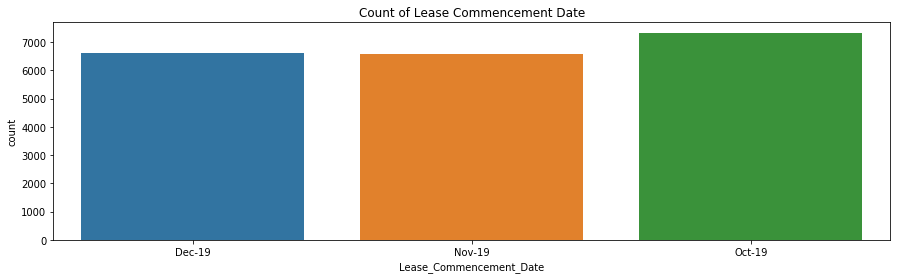

In [65]:
plt.figure(figsize = (15,4))
ax = sns.countplot(x = 'Lease_Commencement_Date', data = df)
ax.set_title('Count of Lease Commencement Date')

Text(0.5, 1.0, 'Count of Property Type')

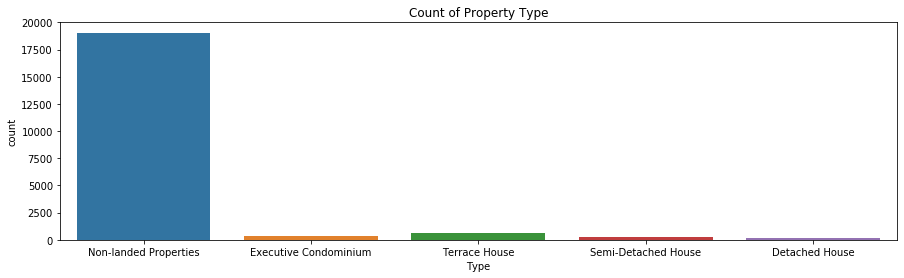

In [66]:
plt.figure(figsize = (15,4))
ax = sns.countplot(x = 'Type', data = df)
ax.set_title('Count of Property Type')

Text(0.5, 1.0, 'Count of Postal District')

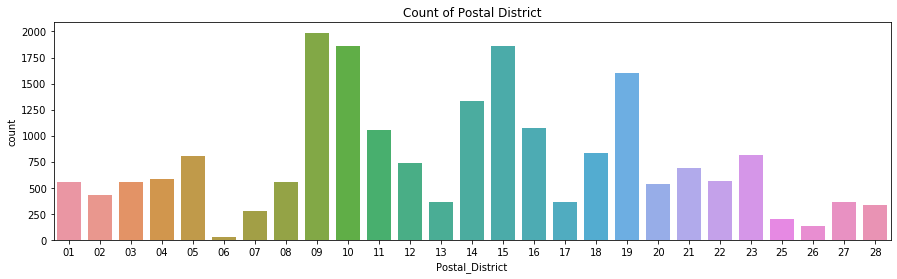

In [67]:
plt.figure(figsize = (15,4))
ax = sns.countplot(x = 'Postal_District', data = df)
ax.set_title('Count of Postal District')

Text(0.5, 1.0, 'Count of Floor Area')

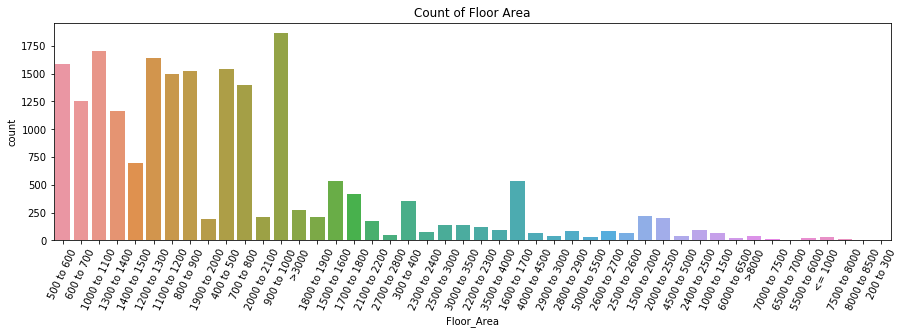

In [68]:
plt.figure(figsize = (15,4))
ax = sns.countplot(x = 'Floor_Area', data = df)
plt.setp(ax.get_xticklabels(), rotation=65)
ax.set_title('Count of Floor Area')